In [1]:
import cv2
import os
import mediapipe as mp
import numpy as np
from tqdm import tqdm

In [2]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
POSE_LANDMARKS = mp_pose.PoseLandmark

# Camera setup
CAMERA_POINT = (0.5, 0.0, 0.0)

# Pairs for horizontal flipping
LEFT_RIGHT_PAIRS = [
    (POSE_LANDMARKS.LEFT_SHOULDER, POSE_LANDMARKS.RIGHT_SHOULDER),
    (POSE_LANDMARKS.LEFT_ELBOW, POSE_LANDMARKS.RIGHT_ELBOW),
    (POSE_LANDMARKS.LEFT_WRIST, POSE_LANDMARKS.RIGHT_WRIST),
    (POSE_LANDMARKS.LEFT_HIP, POSE_LANDMARKS.RIGHT_HIP),
    (POSE_LANDMARKS.LEFT_KNEE, POSE_LANDMARKS.RIGHT_KNEE),
    (POSE_LANDMARKS.LEFT_ANKLE, POSE_LANDMARKS.RIGHT_ANKLE),
    (POSE_LANDMARKS.LEFT_FOOT_INDEX, POSE_LANDMARKS.RIGHT_FOOT_INDEX)
]

In [6]:
# Mathematical functions

def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def calculate_angle(a, b, c):
    a, b, c = map(np.array, (a, b, c))
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

def midpoint(p1, p2):
    return [(p1[i] + p2[i]) / 2 for i in range(3)]

In [4]:
# Keypoint extraction from frames

def get_pose_keypoints(image):
    results = pose.pricess(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks:
        return None
    return [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]

In [5]:
def mirror_keypoints(keypoints):
    mirrored = keypoints.copy()

    mirrored = [(1 - x, y, x) for x, y, z in mirrored]

    for left, right in LEFT_RIGHT_PAIRS:
        mirrored[left.value], mirrored[right.value] = mirrored[right.value], mirrored[left.value]
    
    return mirrored

In [7]:
def triangle_angles(a, b, c):
    angle_A = calculate_angle(b, a, c)
    angle_B = calculate_angle(c, b, a)
    angle_C = 180.0 - angle_A - angle_B
    return [angle_A, angle_B, angle_C]

In [9]:
# Feature engineering per frame
def extract_features(keypoints):
    LS = keypoints[POSE_LANDMARKS.LEFT_SHOULDER.value]
    RS = keypoints[POSE_LANDMARKS.RIGHT_SHOULDER.value]
    LH = keypoints[POSE_LANDMARKS.LEFT_HIP.value]
    RH = keypoints[POSE_LANDMARKS.RIGHT_HIP.value]
    LF = keypoints[POSE_LANDMARKS.LEFT_FOOT_INDEX.value]
    RF = keypoints[POSE_LANDMARKS.RIGHT_FOOT_INDEX.value]
    cam = CAMERA_POINT

    features = []

    # Shoulder group
    shoulder_width = np.linalg.norm(LS - RS)
    shoulder_triangle = triangle_angles(LS, cam, RS)
    features.extend([
        shoulder_width,  # Distance between shoulders
        *shoulder_triangle  # Angles of the triangle formed by shoulders and camera
    ])
    
    # Hip group
    hip_width = np.linalg.norm(LH - RH)
    hip_triangle = triangle_angles(LH, cam, RH)
    features.extend([
        hip_width,  # Distance between hips
        *hip_triangle  # Angles of the triangle formed by hips and camera
    ])

    # Stride group
    stride = np.linalg.norm(LF - RF)
    features.append(stride)  # Distance between feet

    return features


In [57]:
def trim_by_time(video_path, num_frames=10, fps_trim_start=1, fps_trim_end=2):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    start_frame = int(fps * fps_trim_start)
    end_frame = int(total_frames - fps * fps_trim_end)

    if end_frame - start_frame < num_frames:
        raise ValueError("Not enough frames after trimming to extract the required number of frames.")
        cap.release()
        return None
    
    selected_indices = np.linspace(start_frame, end_frame, num_frames, dtype=int)

    trimmed_frames = []
    current_index = 0
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_id == selected_indices[current_index]:
            trimmed_frames.append(frame)
            current_index += 1
            if current_index >= len(selected_indices):
                break
        frame_id += 1

    cap.release()
    return trimmed_frames

In [11]:
def filter_frames(video_path, num_frames=10, bbox_x=(0.2, 0.8), bbox_y=(0.0, 0.9)):
    cap = cv2.VideoCapture(video_path)
    filtered_features = []
    filtered_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
    
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)
        
        if results.pose_landmarks:
            keypoints = [(lmk.x, lmk.y, lmk.z) for lmk in results.pose_landmarks.landmark]
            if len(keypoints) == 33:
                center_x = np.mean([keypoints[POSE_LANDMARKS.LEFT_SHOULDER.value][0],
                                    keypoints[POSE_LANDMARKS.RIGHT_SHOULDER.value][0],
                                    keypoints[POSE_LANDMARKS.LEFT_HIP.value][0],
                                    keypoints[POSE_LANDMARKS.RIGHT_HIP.value][0]])
                center_y = np.mean([keypoints[POSE_LANDMARKS.LEFT_SHOULDER.value][1],
                                    keypoints[POSE_LANDMARKS.RIGHT_SHOULDER.value][1],
                                    keypoints[POSE_LANDMARKS.LEFT_HIP.value][1],
                                    keypoints[POSE_LANDMARKS.RIGHT_HIP.value][1]])
                
                if bbox_x[0] < center_x < bbox_x[1] and bbox_y[0] < center_y < bbox_y[1]:
                    filtered_frames.append(frame)
    
    cap.release()

    if len(filtered_frames) < num_frames:
        print(f"Warning: Not enough frames after filtering. Found {len(filtered_frames)} frames.")
        return None
    
    indices = np.linspace(0, len(filtered_frames) - 1, num_frames, dtype=int)
    selected_frames = [filtered_frames[i] for i in indices]

    return selected_frames
                


In [55]:
selected_frames = trim_by_time(test_vid)

In [58]:
def get_video_fps(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return fps

In [62]:
get_video_fps(test_vid)

29.935

In [63]:
def get_total_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

In [65]:
total_frames_slow = get_total_frames(test_vid_slow)
total_frames = get_total_frames(test_vid)

start_ratio = 30/total_frames
end_ratio = 60/total_frames

In [68]:
total_frames

235

In [67]:
end_ratio

0.2553191489361702

In [69]:
start_ratio

0.1276595744680851

In [110]:
def find_last_pose_frame(video_path, detection_confidence=0.5):
    cap = cv2.VideoCapture(video_path)
    pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=detection_confidence)

    last_valid_frame = -1
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            last_valid_frame = frame_idx
        
        frame_idx += 1

    cap.release()
    pose.close()
    return last_valid_frame

In [111]:
def get_middle_frames(video_path, num_frames=10, trim_start_ratio=0.15):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    filename = video_path.split(os.path.sep)[-1].lower()

    if "enter" in filename:
        last_frame = find_last_pose_frame(video_path)
        if last_frame == -1 or last_frame < num_frames:
            print(f"[Warning] Could not find valid pose in {video_path}")
            cap.release()
            return None
        start_frame = max(0, last_frame - num_frames // 2)
        end_frame = min(last_frame + 1, total_frames - 1)
    else:
        trim_end_ratio = 0.5 if fps < 25 else 0.35
        start_frame = int(trim_start_ratio * total_frames)
        end_frame = total_frames - int(trim_end_ratio * total_frames)

    if end_frame - start_frame < num_frames:
        print("Not enough frames after trimming to extract the required number of frames.")
        cap.release()
        return None
    
    selected_indices = np.linspace(start_frame, end_frame-1, num_frames, dtype=int)

    frames = []
    current_index = 0
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_id == selected_indices[current_index]:
            frames.append(frame)
            current_index += 1
            if current_index >= len(selected_indices):
                break
    
        frame_id += 1
    
    cap.release()
    return frames

In [172]:
def find_dynamic_trim_end_frame(
        video_path,
        extra_frames=10,
        detection_confidence=0.5,
        fallback_trim_ratio=0.3,
        min_bottom_middle_frames=3
):
    cap = cv2.VideoCapture(video_path)
    pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=detection_confidence)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    bottom_y_threshold = 0.5
    center_x_min = 0.2
    center_x_max = 0.8

    frame_idx = 0

    bottom_middle_streak = 0
    skeleton_was_visible = False
    vanish_candidate_frame = -1
    vanish_buffer_frames = 5
    no_skeleton_streak = 0
    no_skeleton_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        skeleton_present = False
        landmarks = None
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            visibility_scores = [lm.visibility for lm in landmarks if lm.visibility is not None]
            if len(landmarks) >= 10 and max(visibility_scores, default=0) > 0.3:
                skeleton_present = True

        if skeleton_present:
            left_shoulder = landmarks[POSE_LANDMARKS.LEFT_SHOULDER.value]
            right_shoulder = landmarks[POSE_LANDMARKS.RIGHT_SHOULDER.value]

            shoulder_x = (left_shoulder.x + right_shoulder.x) / 2
            shoulder_y = (left_shoulder.y + right_shoulder.y) / 2

            if shoulder_y > bottom_y_threshold and center_x_min < shoulder_x < center_x_max:
                bottom_middle_streak += 1
            else:
                bottom_middle_streak = 0

            no_skeleton_streak = 0
        
        else:
            no_skeleton_streak += 1
            print(f"No skeleton detected at frame {frame_idx}, streak: {no_skeleton_streak}")
            no_skeleton_frames.append(frame_idx)

            if skeleton_was_visible and bottom_middle_streak >= min_bottom_middle_frames and no_skeleton_streak >= vanish_buffer_frames:
                vanish_candidate_frame = frame_idx
                print(f"Skeleton vanished after bottom-middle at frame {vanish_candidate_frame}")
                break
                
        
        skeleton_was_visible = skeleton_present
        frame_idx += 1
    cap.release()
    pose.close()

    if vanish_candidate_frame != -1:
        trim_end_frame = min(vanish_candidate_frame + extra_frames, total_frames - 1)
        print(f"Using vanish frame + extra frames: {trim_end_frame}")
        return trim_end_frame, no_skeleton_frames
    
    fallback_trim = int(total_frames * (1 - fallback_trim_ratio))
    print(f"No vanish frame found, using fallback trimming at frame {fallback_trim}")
    return fallback_trim, no_skeleton_frames

In [112]:
frames = get_middle_frames(test_vid, num_frames=10, trim_start_ratio=start_ratio)

Not enough frames after trimming to extract the required number of frames.


In [106]:
for i, frame in enumerate(frames):
    cv2.imshow(f"Filtered Frame {i}", frame)
    cv2.waitKey(1000)
cv2.destroyAllWindows()

In [130]:

def show_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    ret, frame = cap.read()
    if not ret:
        print(f"Could not read frame {frame_number}")
        return

    cv2.imshow(f"Frame {frame_number}", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cap.release()

In [169]:
test_vid_slow = "C:/Users/hanna/Documents/Thesis/datainsamling/data/SLOW_side_pass/side_pass_5.mp4"
test_vid = "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_6.mp4"

In [171]:
show_frame(test_vid, 70)

In [173]:
trim_end_frame = find_dynamic_trim_end_frame(
    video_path=test_vid,
    extra_frames=10,
    fallback_trim_ratio=0.3
)



No skeleton detected at frame 0, streak: 1
No skeleton detected at frame 1, streak: 2
No skeleton detected at frame 2, streak: 3
No skeleton detected at frame 3, streak: 4
No skeleton detected at frame 4, streak: 5
No skeleton detected at frame 5, streak: 6
No skeleton detected at frame 6, streak: 7
No skeleton detected at frame 7, streak: 8
No skeleton detected at frame 8, streak: 9
No skeleton detected at frame 14, streak: 1
No skeleton detected at frame 15, streak: 2
No skeleton detected at frame 16, streak: 3
No skeleton detected at frame 17, streak: 4
No skeleton detected at frame 18, streak: 5
No skeleton detected at frame 19, streak: 6
No skeleton detected at frame 20, streak: 7
No skeleton detected at frame 23, streak: 1
No skeleton detected at frame 24, streak: 2
No skeleton detected at frame 28, streak: 1
No skeleton detected at frame 30, streak: 1
No skeleton detected at frame 31, streak: 2
No skeleton detected at frame 32, streak: 3
No skeleton detected at frame 34, streak:

In [149]:
import matplotlib.pyplot as plt

def plot_skeleton_absence(no_skeleton_dict, ground_truth_dict, total_frames_dict):
    plt.figure(figsize=(12, len(no_skeleton_dict) * 0.6))

    for idx, (video_name, no_skeleton_frames) in enumerate(no_skeleton_dict.items()):
        y = [idx] * len(no_skeleton_frames)
        plt.scatter(no_skeleton_frames, y, label=video_name, marker='o', color='red', s=10)

        if video_name in ground_truth_dict:
            vanish_frame = ground_truth_dict[video_name]
            plt.axvline(x=vanish_frame, color='blue', linestyle='--')
        
        total = total_frames_dict.get(video_name, max(no_skeleton_frames, default=0))
        plt.text(total+2, idx, f"{video_name}", va='center', fontsize=8)
    
    plt.xlabel("Frame Index")
    plt.ylabel("Video Index")
    plt.title("No skeleton detection frames per video")
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.4)
    plt.show()

In [150]:
side_video_paths= [
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_2.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_6.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_10.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_14.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/side_enter/side_enter_17.mp4"
]

front_video_paths = [
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_2.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_6.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_10.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_14.mp4",
    "C:/Users/hanna/Documents/Thesis/datainsamling/data/front_enter/front_enter_17.mp4"
]

In [155]:
no_skeleton_dict = {}
side_ground_truth = []
front_ground_truth = []
total_frames = {}

for path in side_video_paths:
    video_name = os.path.basename(path)
    trim_frame, no_skeleton_frames = find_dynamic_trim_end_frame(path)
    no_skeleton_dict[video_name] = no_skeleton_frames
    total_frames[video_name] = get_total_frames(path)

No vanish frame found, using fallback trimming at frame 155
No vanish frame found, using fallback trimming at frame 158
No vanish frame found, using fallback trimming at frame 159
No vanish frame found, using fallback trimming at frame 154
No vanish frame found, using fallback trimming at frame 154


In [156]:
no_skeleton_dict

{'side_enter_2.mp4': [32, 39, 114],
 'side_enter_6.mp4': [14, 23, 28, 30, 34, 37, 45, 59, 72],
 'side_enter_10.mp4': [1,
  3,
  5,
  8,
  14,
  20,
  28,
  31,
  37,
  39,
  43,
  45,
  47,
  63,
  106,
  111,
  119,
  121,
  128,
  136,
  151,
  161,
  164,
  166,
  168,
  170,
  187,
  192,
  218,
  221],
 'side_enter_14.mp4': [3, 5, 12, 15, 19, 21, 25, 32, 39, 41, 43, 45],
 'side_enter_17.mp4': [3, 17, 19, 22, 24, 43, 48]}

In [115]:
cap = cv2.VideoCapture(test_vid)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

trim_start = int(total_frames * 0.1)

def extract_frames_between(video_path, start_frame, end_frame, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total = end_frame - start_frame
    step = max(1, total // num_frames)

    for i in range(start_frame, end_frame, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()
    return frames


In [116]:
selected_frames = extract_frames_between(test_vid, trim_start, trim_end_frame, num_frames=10)

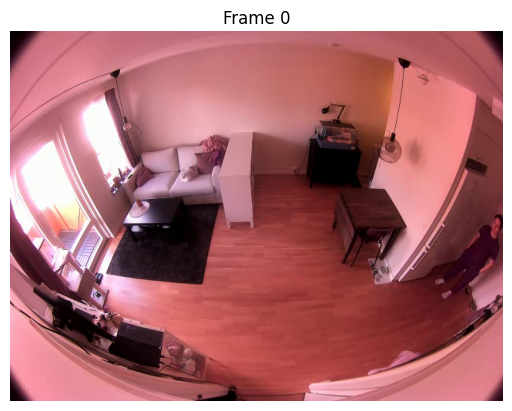

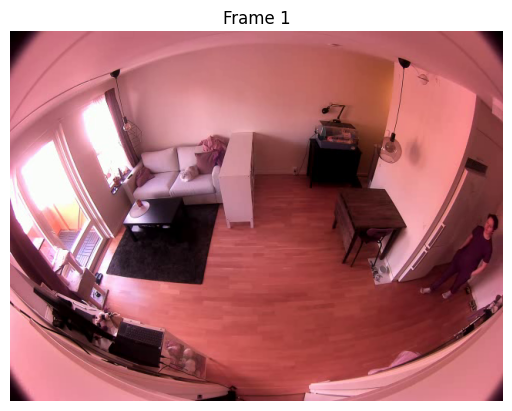

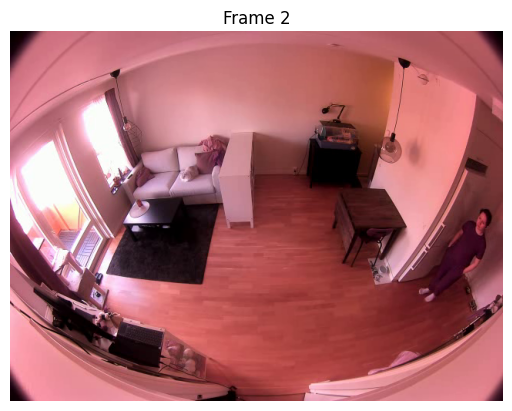

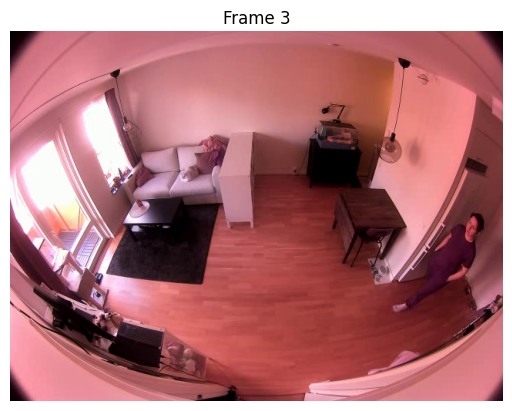

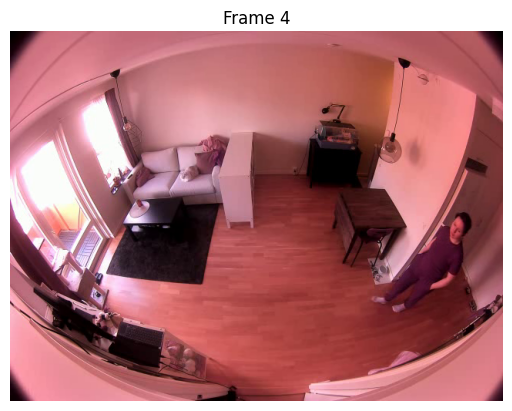

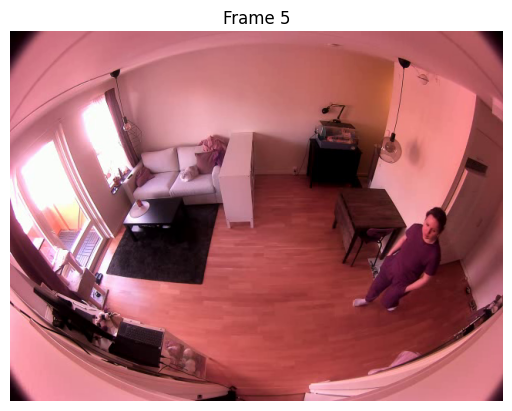

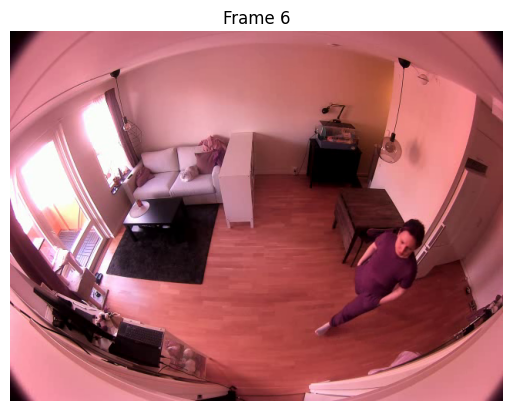

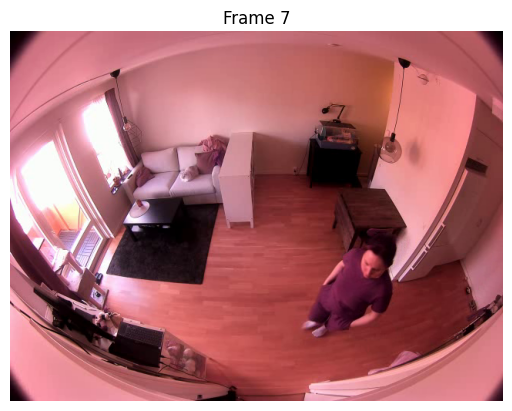

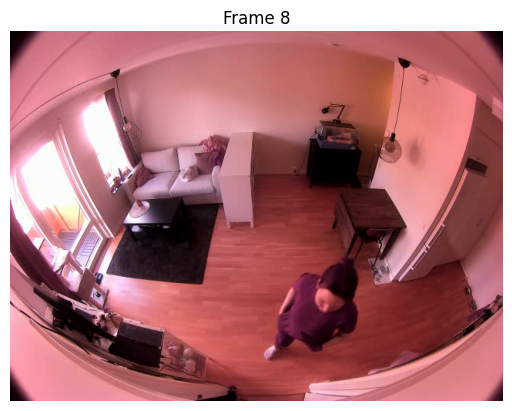

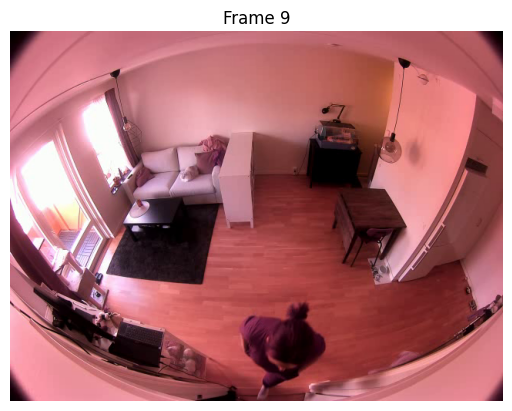

In [117]:
import matplotlib.pyplot as plt
for idx, f in enumerate(selected_frames):
    plt.imshow(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {idx}")
    plt.axis('off')
    plt.show()